In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import numpy as np
import copy

In [2]:
from OpSimSummary import summarize_opsim as oss
import sncosmo

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
from metrics import PerSNMetric
from efficiencyTable import EfficiencyTable

In [4]:
from lsst.sims.photUtils import BandpassDict

In [5]:
from lsst.sims.utils.coordinateTransformations import haversine

In [6]:
# Catsim bandpasses
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [7]:
# sncosmo Bandpasses required for fitting
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


In [8]:
import psops as testps

In [9]:
lsstReq = testps.LSSTReq

In [10]:
lsstReq

{'Duration': 3650.0, 'bF': u    1
 g    1
 r    1
 i    1
 z    1
 y    1
 dtype: float64, 'meanNumVisits': u     56
 g     80
 r    184
 i    184
 z    160
 y    160
 dtype: float64, 'medianSVD': u    23.9
 g    25.0
 r    24.7
 i    24.0
 z    23.3
 y    22.1
 dtype: float64}

In [11]:
x = testps.LSST_Obs(mjd_center=49540, lsstrequirements=lsstReq)

In [12]:
x.bumpFactors

u    1
g    1
r    1
i    1
z    1
y    1
dtype: float64

In [13]:
lc = x.obsValues()

In [14]:
lc.head()

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night
0,49510.000000,g,0,0,25,1,49510
1,49536.666667,g,0,0,25,1,49536
2,49563.333333,g,0,0,25,1,49563
3,49510.000000,i,0,0,24,1,49510
4,49526.000000,i,0,0,24,1,49526


In [15]:
q = PerSNMetric(summarydf=lc, t0=49540, raCol='ra', decCol='dec', lsst_bp=lsst_bp, fieldID=None)

In [16]:
mcmc_out = sncosmo.mcmc_lc(q.SNCosmoLC(nightlyCoadd=True), model=q.sncosmoModel, 
                vparam_names=['t0', 'x0', 'x1', 'c'], 
                bounds={'c':(-1., 1.), 'x1':(-5.0, 5.0)}, 
                minsnr=0.)

19


In [17]:
import analyzeSN as ans
from corner import corner

metrics.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['modelFlux'] = lc['flux']
metrics.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['deviation'] = np.random.normal(size=len(lc['flux']))


19


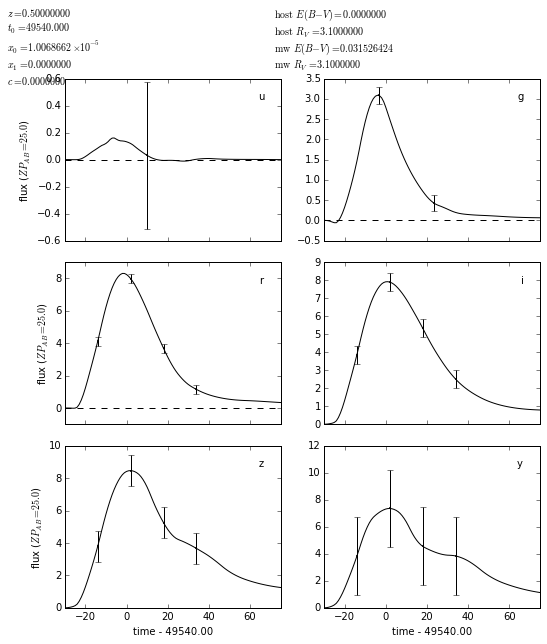

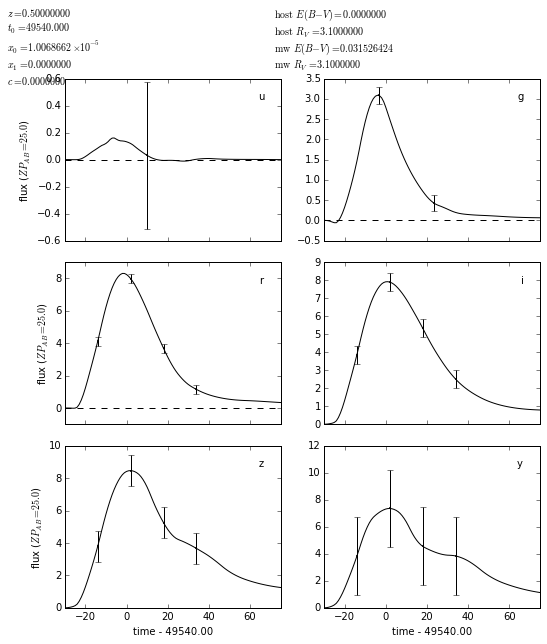

In [19]:
q.lcplot()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


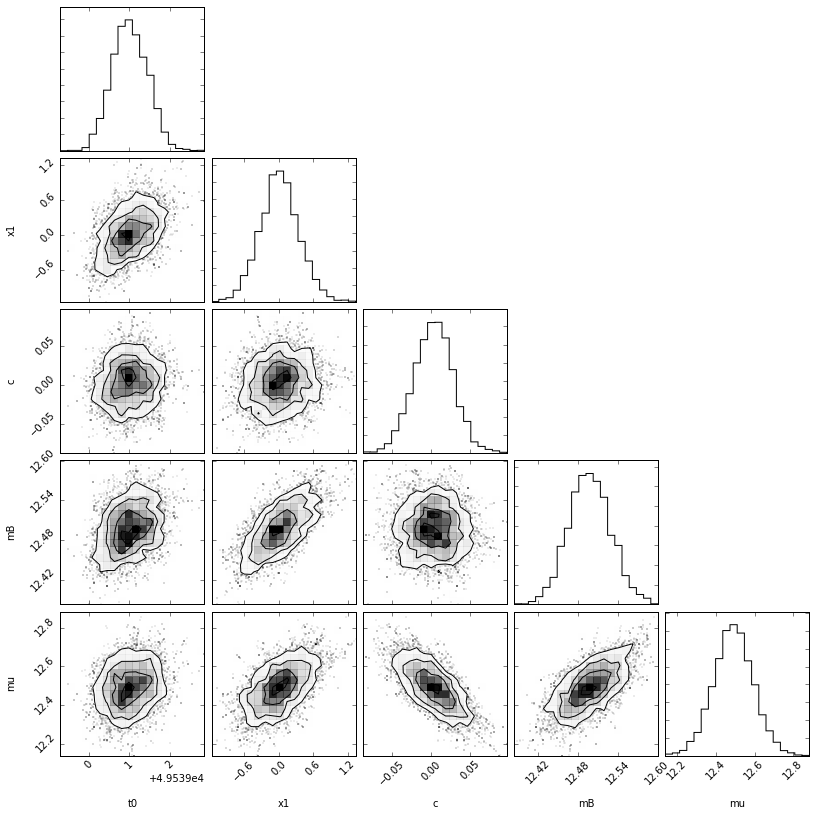

In [18]:
noscatter = ans.ResChar.fromSNCosmoRes(mcmc_out)
fig_noScatter = corner(noscatter.salt_samples().values, labels=noscatter.salt_samples().columns)

In [26]:
y = testps.LSST_Obs(mjd_center=49540, lsstrequirements=lsstReq)

In [27]:
y.bumpFactors = 0.5 * y.bumpFactors

In [28]:
y.bumpFactors

u    0.5
g    0.5
r    0.5
i    0.5
z    0.5
y    0.5
dtype: float64

In [29]:
q2 = PerSNMetric(summarydf=y.obsValues(), t0=49540, raCol='ra', decCol='dec', lsst_bp=lsst_bp, fieldID=None)

10


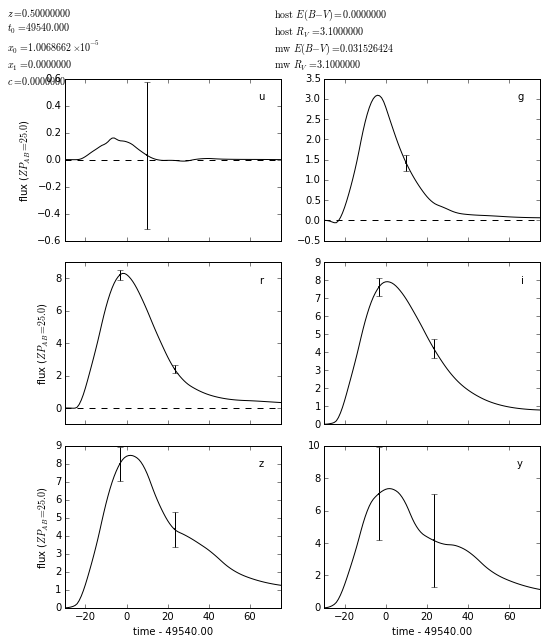

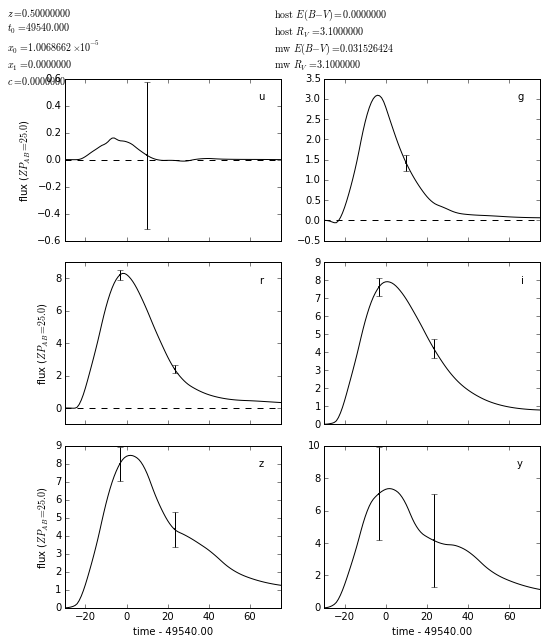

In [114]:
q2.lcplot()

In [115]:
mcmc_out = sncosmo.mcmc_lc(q2.SNCosmoLC(nightlyCoadd=True), model=q.sncosmoModel, 
                vparam_names=['t0', 'x0', 'x1', 'c'], 
                bounds={'c':(-1., 1.), 'x1':(-5.0, 5.0)}, 
                minsnr=0.)

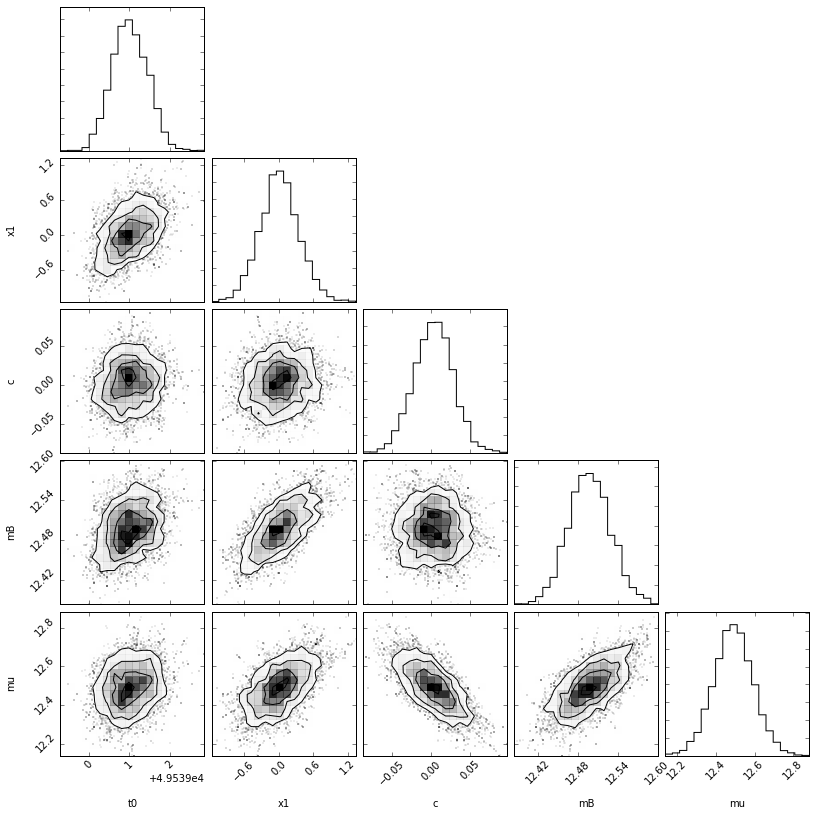

In [116]:
y_noscatter = ans.ResChar.fromSNCosmoRes(mcmc_out)
fig_y_noScatter = corner(noscatter.salt_samples().values, labels=noscatter.salt_samples().columns)

In [39]:
y_noscatter.salt_samples().mu.var() / noscatter.salt_samples().mu.var()

12.42876690621849

In [84]:
z = testps.LSST_Obs(mjd_center=49540, lsstrequirements=lsstReq)

In [85]:
z.bumpFactors = 0.25  * z.bumpFactors

In [86]:
z.bumpFactors

u    0.25
g    0.25
r    0.25
i    0.25
z    0.25
y    0.25
dtype: float64

In [87]:
qz = PerSNMetric(summarydf=z.obsValues(), t0=49540, raCol='ra', decCol='dec', lsst_bp=lsst_bp, fieldID=None)

In [88]:
qz.df

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night,MJDay
0,49510,g,0,0,25.0,1,49510,49510
1,49510,i,0,0,24.0,1,49510,49510
2,49550,i,0,0,24.0,1,49550,49550
3,49510,r,0,0,24.7,1,49510,49510
4,49550,r,0,0,24.7,1,49550,49550
5,49510,u,0,0,23.9,1,49510,49510
6,49510,Y,0,0,22.1,1,49510,49510
7,49550,Y,0,0,22.1,1,49550,49550
8,49510,z,0,0,23.3,1,49510,49510
9,49550,z,0,0,23.3,1,49550,49550


In [89]:
z.obsValues()

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night
0,49510,g,0,0,25.0,1,49510
1,49510,i,0,0,24.0,1,49510
2,49550,i,0,0,24.0,1,49550
3,49510,r,0,0,24.7,1,49510
4,49550,r,0,0,24.7,1,49550
5,49510,u,0,0,23.9,1,49510
6,49510,y,0,0,22.1,1,49510
7,49550,y,0,0,22.1,1,49550
8,49510,z,0,0,23.3,1,49510
9,49550,z,0,0,23.3,1,49550


In [93]:
qz.df

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night,MJDay
0,49510,g,0,0,25.0,1,49510,49510
1,49510,i,0,0,24.0,1,49510,49510
2,49550,i,0,0,24.0,1,49550,49550
3,49510,r,0,0,24.7,1,49510,49510
4,49550,r,0,0,24.7,1,49550,49550
5,49510,u,0,0,23.9,1,49510,49510
6,49510,Y,0,0,22.1,1,49510,49510
7,49550,Y,0,0,22.1,1,49550,49550
8,49510,z,0,0,23.3,1,49510,49510
9,49550,z,0,0,23.3,1,49550,49550


In [94]:
_dff = qz.df.copy()

In [95]:
_dff['band'] = _dff['filter'].apply(lambda x: x.lower())

In [96]:
_dff

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night,MJDay,band
0,49510,g,0,0,25.0,1,49510,49510,g
1,49510,i,0,0,24.0,1,49510,49510,i
2,49550,i,0,0,24.0,1,49550,49550,i
3,49510,r,0,0,24.7,1,49510,49510,r
4,49550,r,0,0,24.7,1,49550,49550,r
5,49510,u,0,0,23.9,1,49510,49510,u
6,49510,Y,0,0,22.1,1,49510,49510,y
7,49550,Y,0,0,22.1,1,49550,49550,y
8,49510,z,0,0,23.3,1,49510,49510,z
9,49550,z,0,0,23.3,1,49550,49550,z


In [97]:
q.SN

4


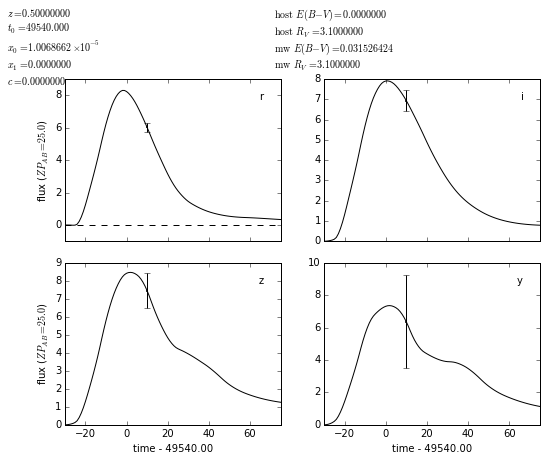

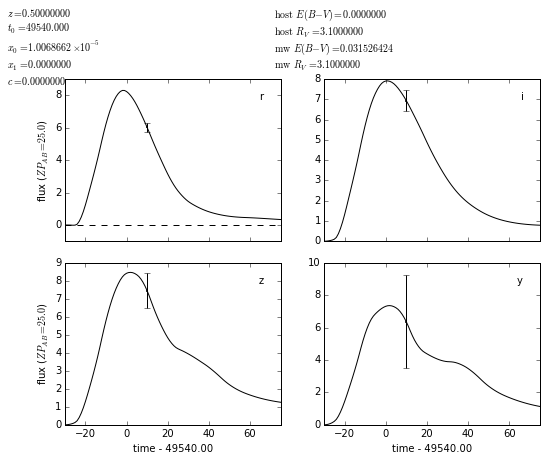

In [113]:
qz.lcplot()

In [106]:
qz_mcmc_out = sncosmo.mcmc_lc(qz.SNCosmoLC(nightlyCoadd=True), model=q.sncosmoModel, 
                vparam_names=['t0', 'x0', 'x1', 'c'], 
                bounds={'c':(-1., 1.), 'x1':(-5.0, 5.0)}, 
                minsnr=0.)

4


In [108]:
qzm = ans.ResChar.fromSNCosmoRes(qz_mcmc_out)

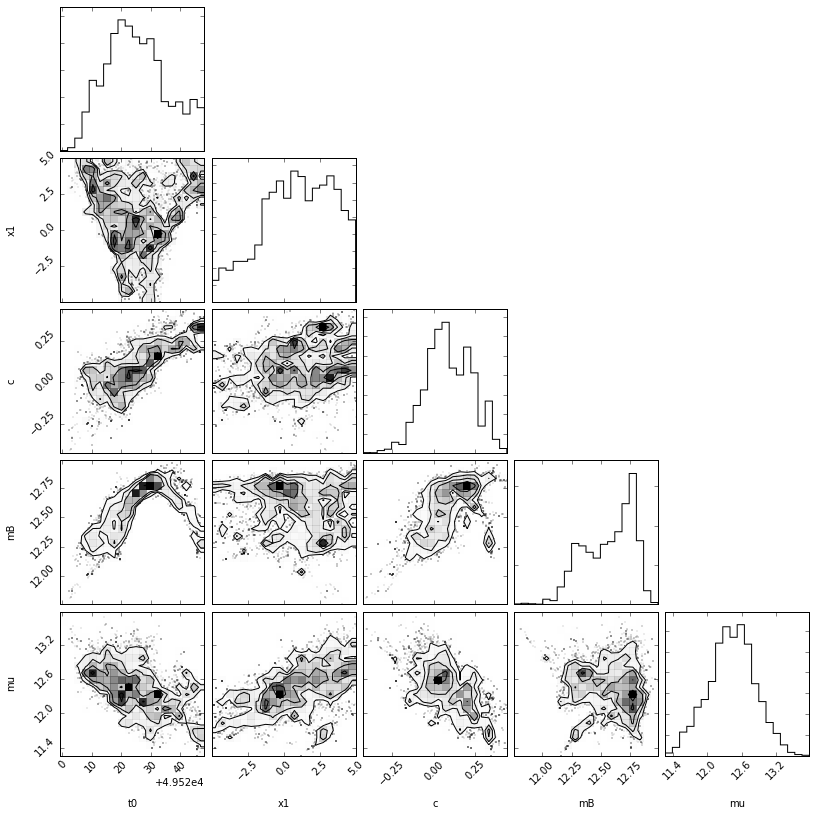

In [109]:
fig_z_noScatter = corner(qzm.salt_samples().values, labels=noscatter.salt_samples().columns)